In [2]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
import json
config = json.load(open('../config.json'))
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [3]:

lr = 0.0005
max_epoch = 30000
dset='nsdsyn'
roi_list = ['V1','V2','V3']
vsc='pRFsize'
nsd_subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
broderick_sn_list = [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]
broderick_subj_list = [utils.sub_number_to_string(i, 'broderick') for i in broderick_sn_list]
ARGS_2D = ['sub','lr','eph','roi']

# NSD 
## model

In [4]:
pt_file_list = []
dset = 'nsdsyn'
roi='V2'
results_dir = os.path.join(config['OUTPUT_DIR'], 'sfp_model', 'results_2D', dset)
for subj in nsd_subj_list:
    file_name = os.path.join(results_dir, f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
nsd_params = model.load_all_models(pt_file_list, *ARGS_2D)

precision_s =  pd.read_csv(os.path.join(config['OUTPUT_DIR'], 'dataframes', dset, 'precision', f'precision-s_dset-{dset}_vs-pRFsize.csv'))
real_df = pd.merge(nsd_params, precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])
real_df['bootstrap'] = 'real'

## Load in bootstraps

In [5]:
pt_file_list = []
dset = 'nsdsyn'
n_bootstrap = 100
for subj in nsd_subj_list:
    for i in range(n_bootstrap):
        file_name = os.path.join(results_dir, 'bootstraps', f'bootstrap-{i}_model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
        pt_file_list.append(file_name)
bootstrap_params = model.load_all_models(pt_file_list, *ARGS_2D+['bootstrap'])

## organize dataframes

In [6]:
param_cols = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'p_3', 'p_4', 'A_1', 'A_2']

# Melt bootstrap data to long format
boot_melted = bootstrap_params.melt(id_vars=['bootstrap','sub'], 
                                    value_vars=param_cols,
                                    var_name='parameter', value_name='value')

# Melt real data
real_melted = real_df.melt(id_vars=['sub','bootstrap'], 
                            value_vars=param_cols, 
                            var_name='parameter', 
                            value_name='value')


In [7]:
# Compute 16th and 84th percentiles for each group
ci_df = boot_melted.groupby(['sub', 'parameter'])['value'].quantile([0.16, 0.84]).unstack(level=-1).reset_index()
ci_df = ci_df.rename(columns={0.16: 'ci_low_16', 0.84: 'ci_high_84'})

In [8]:
plot_df =pd.merge(real_melted[['sub','parameter','value']], ci_df, on=['sub', 'parameter'])

# Compute error bar length
plot_df['yerr_lower'] = plot_df['value'] - plot_df['ci_low_16']
plot_df['yerr_upper'] = plot_df['ci_high_84'] - plot_df['value']
#yerr = np.vstack([plot_df['yerr_lower'], plot_df['yerr_upper']])
plot_df

,sub,parameter,value,ci_low_16,ci_high_84,yerr_lower,yerr_upper
0,subj01,sigma,5.655971,4.763788,7.103287,0.892182,1.447317
1,subj02,sigma,3.959743,3.494461,10.066614,0.465282,6.106872
2,subj03,sigma,3.321069,3.121617,3.947851,0.199452,0.626782
3,subj04,sigma,3.948785,3.494776,4.891348,0.454009,0.942562
4,subj05,sigma,3.324115,2.771347,3.630846,0.552767,0.306731
...,...,...,...,...,...,...,...
67,subj04,A_2,-0.004421,-0.012221,0.006218,0.007800,0.010639
68,subj05,A_2,-0.000032,-0.036094,-0.011498,0.036063,-0.011466
69,subj06,A_2,-0.036121,-0.046472,-0.030855,0.010351,0.005266
70,subj07,A_2,0.009285,-0.002295,0.015620,0.011580,0.006335


In [9]:
plot_df =pd.merge(real_melted, ci_df, on=['sub', 'parameter'])

# Compute error bar length
plot_df['yerr_lower'] = plot_df['value'] - plot_df['ci_low_16']
plot_df['yerr_upper'] = plot_df['ci_high_84'] - plot_df['value']
tmp = plot_df.query('sub == "subj01"')

In [10]:
PARAMS_2D = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'p_3', 'p_4', 'A_1', 'A_2']
weighted_mean_df =utils.calculate_weighted_mean(real_df, PARAMS_2D, 'precision')

In [11]:
weighted_mean_df['sub'] = 'weighted mean'
weighted_mean_df_melted = pd.melt(weighted_mean_df.drop(columns=['vroinames']), id_vars=['sub'], 
var_name='parameter', value_name='value')
plot_df =pd.concat((plot_df, weighted_mean_df_melted))

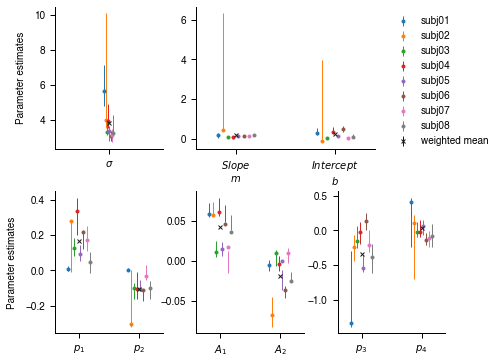

In [12]:
#ylim_list = [(2, 12), (-0.2, 0.6), (-0.4, 0.4),  (-0.1,0.1), (-0.5, 0.5)]
#yticks_list=  [[2,4,6], [-0.2, 0, 0.2, 0.4, 0.6], [-0.4,-0.2,0,0.2,0.4], [-0.1,0,0.1],[-0.5,0,0.5]]

params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1','A_2'], ['p_3','p_4']]

vis2D.plot_individual_parameters(plot_df,
                                 weighted_mean_df=weighted_mean_df,
                                 x='parameter',
                                 y='value', 
                                 hue='sub', 
                                 hue_order=nsd_subj_list + ['weighted mean'], 
                                 params_list=params_list, 
                                 ylim_list=None, 
                                 yticks_list=None,
                                 save_path=os.path.join(config['FIG_DIR'], 'sfp_model', 'results_2D', 'bootstraps', f'errorbars_individual-parameters-{roi}.svg'))

# Plot parameter estimates

(<Figure size 1857.6x324 with 5 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

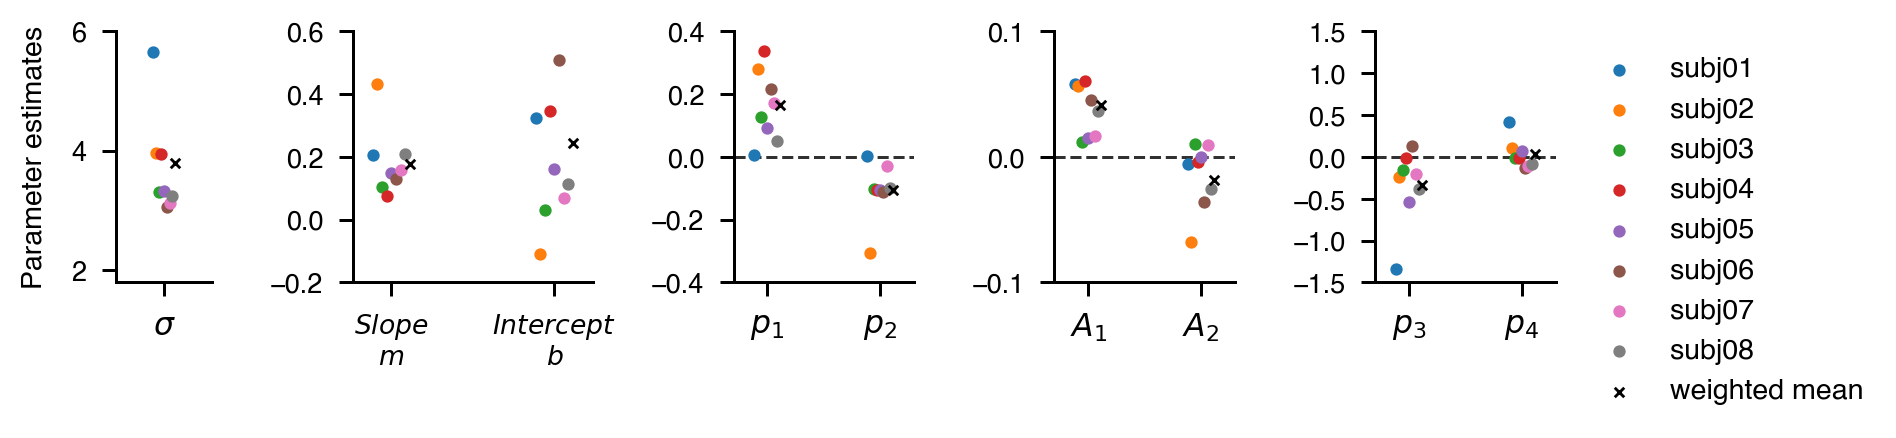

In [18]:
plot_df = pd.concat((real_df, weighted_mean_df), axis=0)

params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1', 'A_2'], ['p_3', 'p_4']]
ylim_list = [(1.8, 6), (-0.2, 0.6), (-0.4, 0.4),  (-0.1,0.1), (-1.5, 1.5)]
yticks_list=  [[2,4,6], [-0.2, 0, 0.2, 0.4, 0.6], [-0.4,-0.2,0,0.2,0.4], [-0.1,0,0.1],[-1.5,-1.0, -0.5,0, 0.5, 1.0, 1.5]]
vis2D.make_param_summary_fig(plot_df, 
                             hue='sub', hue_order=plot_df['sub'].unique(), 
                             pal=sns.color_palette('tab10')[:8] + ['black'], scale=0.7, 
                             ylim_list=ylim_list, yticks_list=yticks_list,
                             weighted_mean=False,
                             width_ratios=(0.8,2,1.5,1.5,1.5), fig_size=(8.6, 1.5),
                             params_list=params_list, **{'markers':['o']*8 + ['x']},
                             save_path=os.path.join(config['FIG_DIR'], 'sfp_model', 'results_2D', 'bootstraps', f'individual-parameters-{roi}.svg'))